#### In this notebook I start first from building a quick EDA revealing patters in the data, then I use EDA insights to build a simple linear model with only essential features (based on a out of time approach).

##### Since we will use Scikit-learn models, let's accelerate them first by using Intel Extension.

* vers. 20 - introduced selective rounding

In [1]:
#%pip install scikit-learn -U

In [2]:
# Intel® Extension for Scikit-learn installation:
#%pip install scikit-learn-intelex

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


##### We then load the data, it is necessary paying attention to convert the date into datetime

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [5]:
# Flag to force to reload dataset
RELOAD = False

In [6]:
# import Kaggle API to load dataset
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
# initialize Kaggle API
api = KaggleApi()
api.authenticate()
# download dataset from Kaggle to data folder
data_path = 'data'
api.competition_download_files('tabular-playground-series-jan-2022', data_path, force=RELOAD)
# save filename: !ATTENTION! : it may not be wroking if many files are in folders
# then just name it manually 
#dataset_file_name = os.listdir(data_path)[0]
dataset_file_name = 'tabular-playground-series-jan-2022.zip'

# import libraries to work with paths and to read zipped file, as was downloaded from Kaggle
import os.path
from zipfile import ZipFile
# Read train dataset (train.csv) to pandas DataFrame named df: it will be used for analysis
df = pd.read_csv(ZipFile(os.path.join(data_path, dataset_file_name)).open('train.csv'), parse_dates=['date'])
# Read test dataset (test.csv), to pandas DataFrame named df_validation. It will be used only to generate final predictions, which will be submitted
df_validation = pd.read_csv(ZipFile(os.path.join(data_path, dataset_file_name)).open('test.csv'), parse_dates=['date'])
# finally, we will download example of submission (there are no correct predictions there, it is just an example)
df_subm_example = pd.read_csv(ZipFile(os.path.join(data_path, dataset_file_name)).open('sample_submission.csv'))

# Check, that all dataframes are loaded and have correct shapes (train should have six columns, 
# test should have 5 columns - no outcome, and sample submission should have two columns)
print('Shape of df: ' + str(df.shape))
print('Shape of df_validation: ' + str(df_validation.shape))
print('Shape of df_subm_example: ' + str(df_subm_example.shape))

Shape of df: (26298, 6)
Shape of df_validation: (6570, 5)
Shape of df_subm_example: (6570, 2)


In [7]:
# Loading train and test data
#train = pd.read_csv("../input/tabular-playground-series-jan-2022/train.csv", parse_dates=['date'])
#test = pd.read_csv("../input/tabular-playground-series-jan-2022/test.csv", parse_dates=['date'])
train = df
test = df_validation

In [8]:
train.dtypes

row_id               int64
date        datetime64[ns]
country             object
store               object
product             object
num_sold             int64
dtype: object

##### Before starting with EDA, it is important to check about the data structure. Apparently we have a combination of time series based on countries, stores and products. Let's first check if all the combinations appear in train and test.

In [9]:
# figuring out the theoretically possible level combination
time_series = ['country', 'store', 'product']
combinations = 1
for feat in time_series:
    combinations *= train[feat].nunique()
    
print(f"There are {combinations} possible combinations")

There are 18 possible combinations


In [10]:
time_series = ['country', 'store', 'product']
country_store_product_train = train[time_series].drop_duplicates().sort_values(time_series)
country_store_product_test =test[time_series].drop_duplicates().sort_values(time_series)

cond_1 = len(country_store_product_train) == combinations
print(f"Are all theoretical combinations present in train: {cond_1}")
cond_2 = (country_store_product_train == country_store_product_test).all().all()
print(f"Are combinations the same in train and test: {cond_2}")

Are all theoretical combinations present in train: True
Are combinations the same in train and test: True


##### As a second step let's visualize how time is split between train and test.

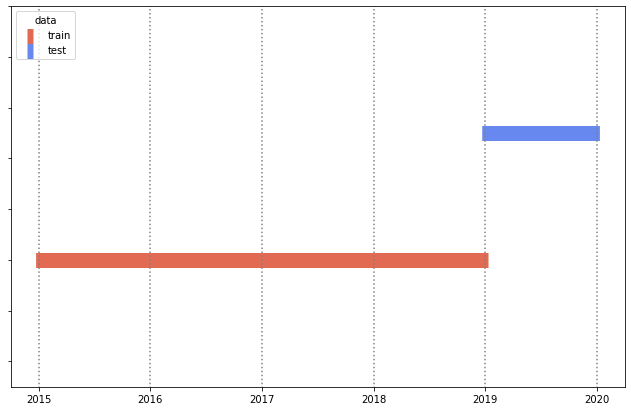

In [11]:
train_dates = train.date.drop_duplicates().sort_values()
test_dates = test.date.drop_duplicates().sort_values()

fig, ax = plt.subplots(1, 1, figsize = (11, 7))
cmap_cv = plt.cm.coolwarm

color_index = np.array([1] * len(train_dates) + [0] * len(test_dates))

ax.scatter(range(len(train_dates)), [.5] * len(train_dates),
           c=color_index[:len(train_dates)], marker='_', lw=15, cmap=cmap_cv,
           label='train', vmin=-.2, vmax=1.2)

ax.scatter(range(len(train_dates), len(train_dates) + len(test_dates)), [.55] * len(test_dates),
           c=color_index[len(train_dates):], marker='_', lw=15, cmap=cmap_cv,
           label='test', vmin=-.2, vmax=1.2)

tick_locations = np.cumsum([0, 365, 366, 365, 365, 365])
for i in (tick_locations):
    ax.vlines(i, 0, 2,linestyles='dotted', colors = 'grey')
    
ax.set_xticks(tick_locations)
ax.set_xticklabels([2015, 2016, 2017, 2018, 2019, 2020], rotation = 0)
ax.set_yticklabels(labels=[])
plt.ylim([0.45, 0.60])
ax.legend(loc="upper left", title="data")

plt.show()

##### Having four complete years available allows various types of testing and modelling. In this EDA we will limit to use the last year available (2018) as an hold-out, setting our baseline model to be able to forecast an entire year in the future.

##### As a last check we verify that no date is missing from train and test:

In [12]:
missing_train = pd.date_range(start=train_dates.min(), end=train_dates.max()).difference(train_dates)
missing_test = pd.date_range(start=test_dates.min(), end=test_dates.max()).difference(test_dates)
print(f"missing dates in train: {len(missing_train)} and in test: {len(missing_test)}")

missing dates in train: 0 and in test: 0


##### Having completed the checks, we process the datetime information, extracting it informative elements at different time granularities:

In [13]:
# We create different time granularity

def process_time(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['week'][df['week']>52] = 52
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    return df

train = process_time(train)
test = process_time(test)

##### We are ready to explore the data. In order to highlight the time series characteristics, we create panels of products x countries x shops. We start by aggregating at a year level.


--- Kaggle Mug ---



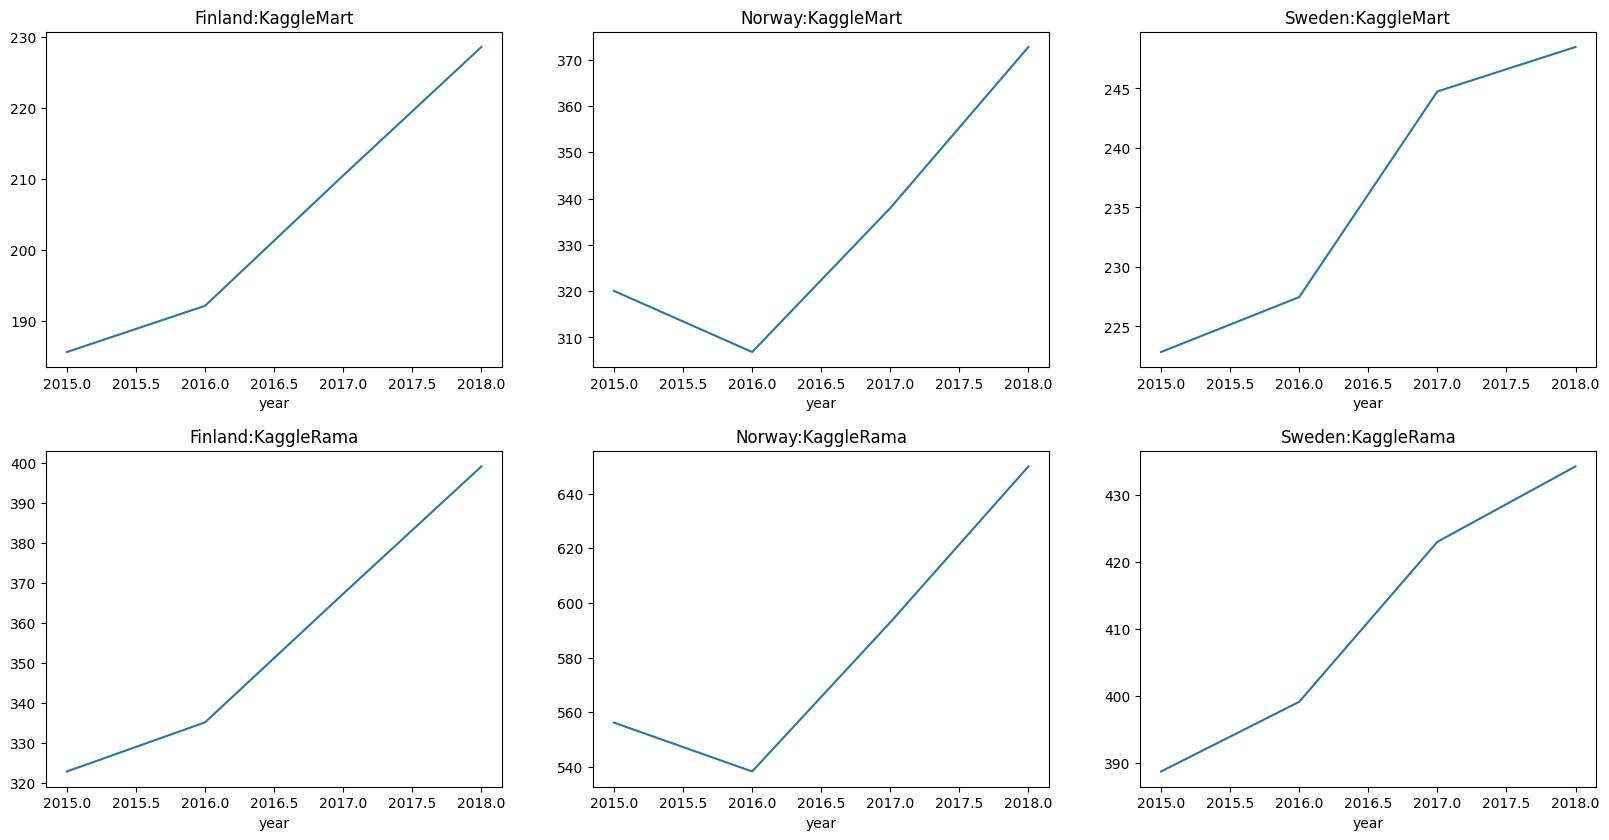


--- Kaggle Hat ---



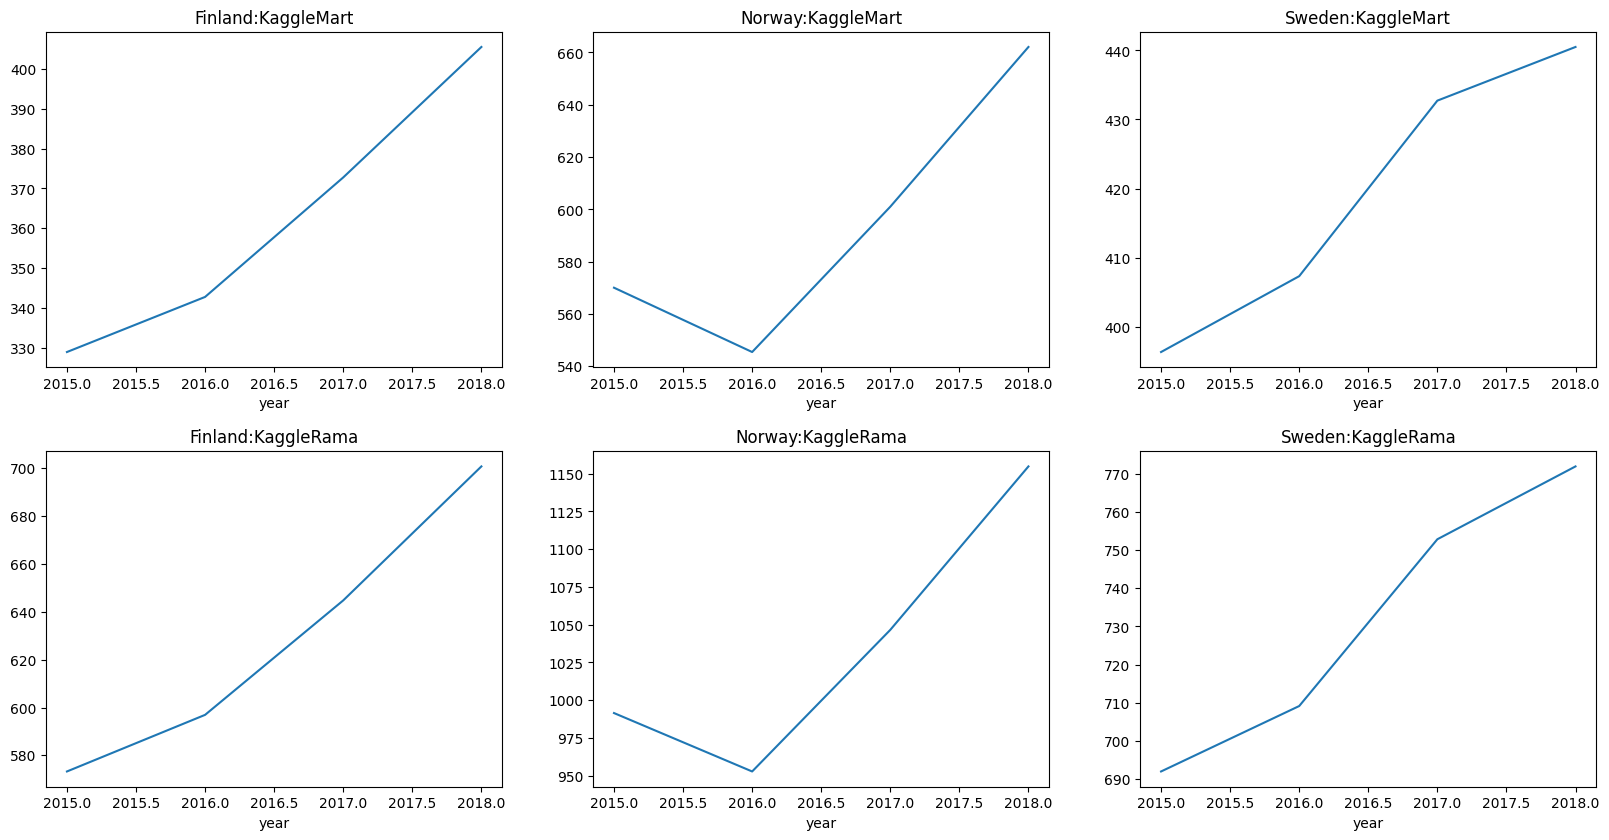


--- Kaggle Sticker ---



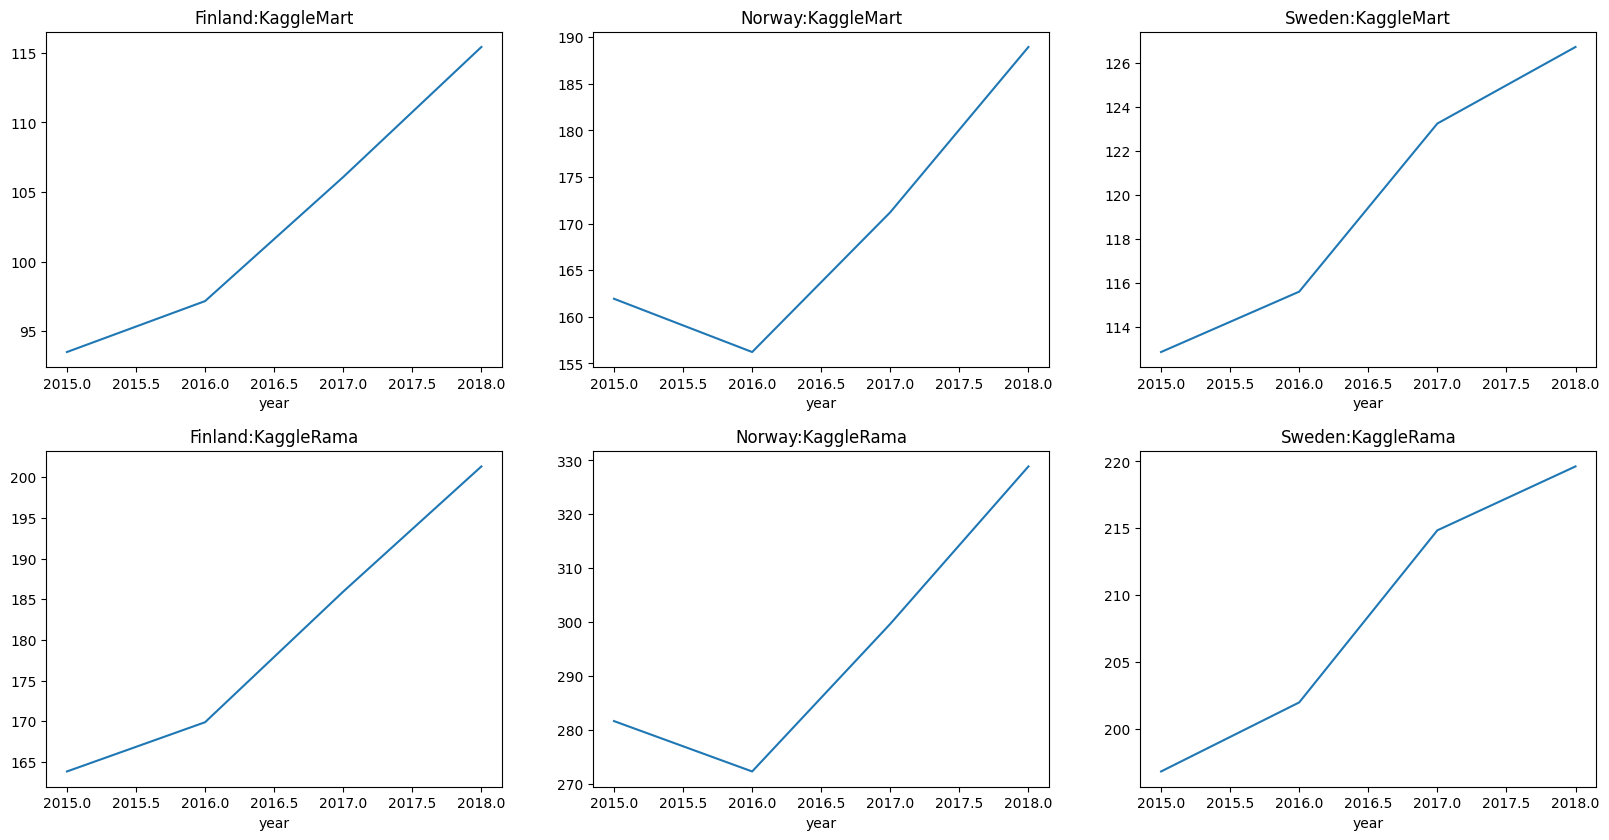

In [14]:
for product in ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']:
    print(f"\n--- {product} ---\n")
    fig = plt.figure(figsize=(20, 10), dpi=100)
    fig.subplots_adjust(hspace=0.25)
    for i, store in enumerate(['KaggleMart', 'KaggleRama']):
        for j, country in enumerate(['Finland', 'Norway', 'Sweden']):
            ax = fig.add_subplot(2, 3, (i*3+j+1))
            selection = (train['country']==country)&(train['store']==store)&(train['product']==product)
            selected = train[selection]
            selected.set_index('date').groupby('year')['num_sold'].mean().plot(ax=ax)
            ax.set_title(f"{country}:{store}")
    plt.show()

##### The first series of panels points out that the country effect is kind of indipendent from store and product. There is an underlying country dynamic that replicates the same no matter the shop or the product sold by it. We also notice that shops differentiate only for the level of sales.

##### Our next panels will explore seaasonality based on months:

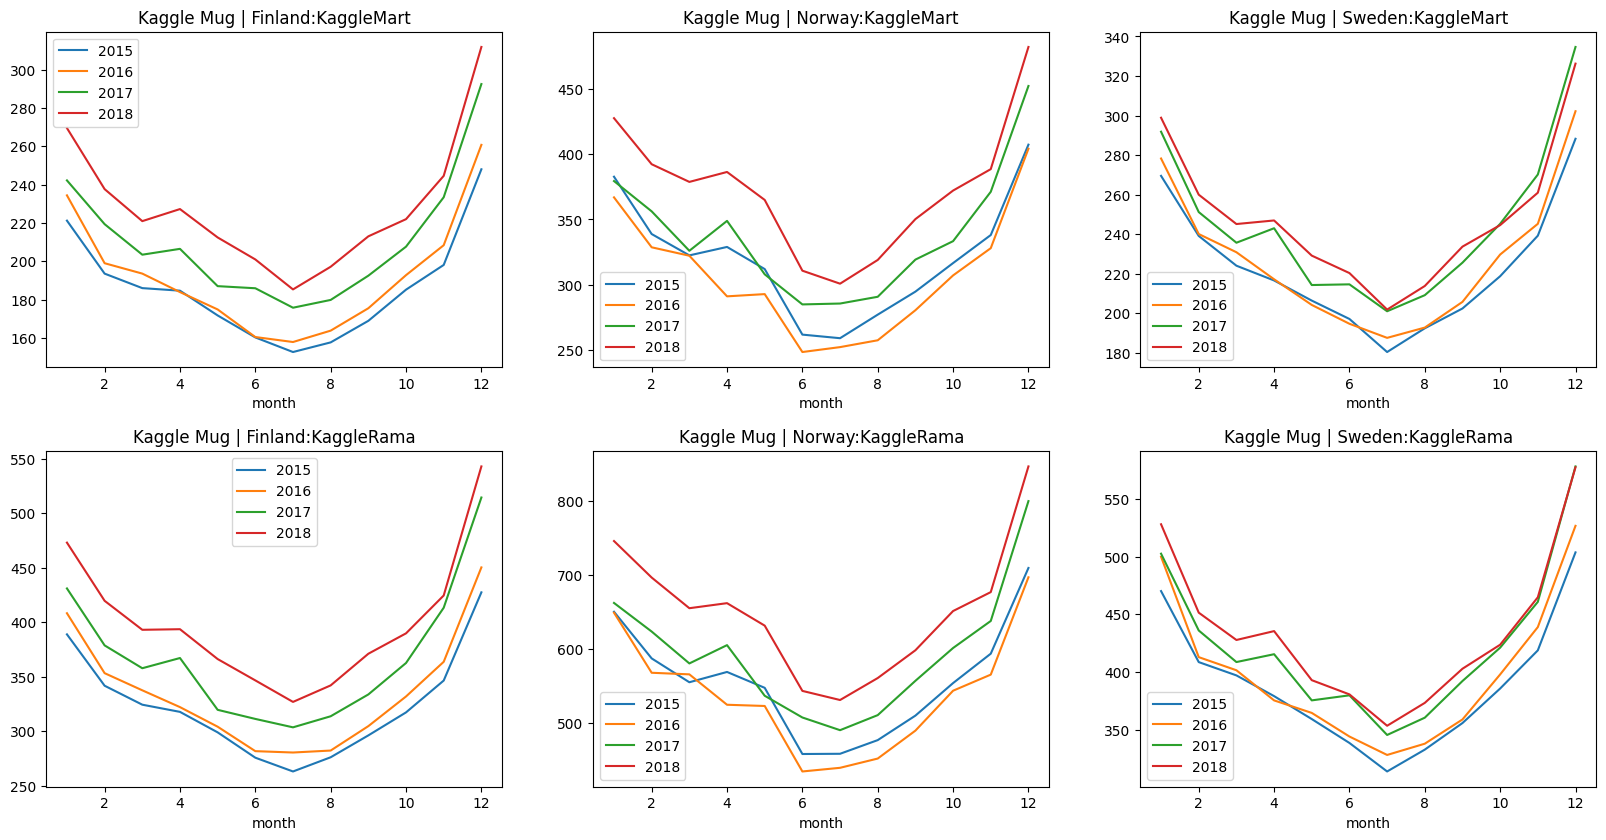

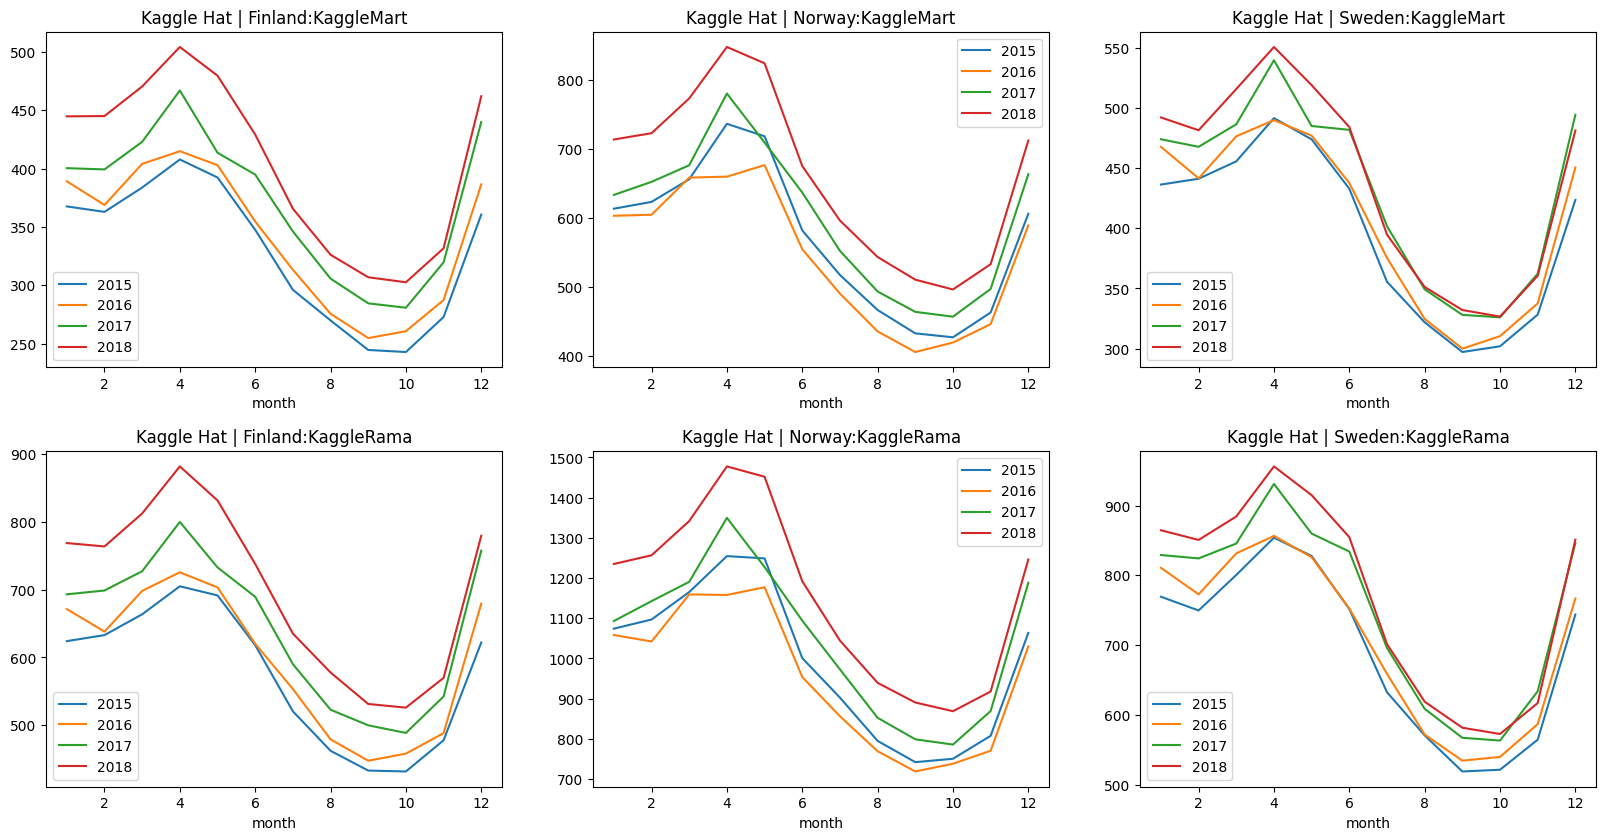

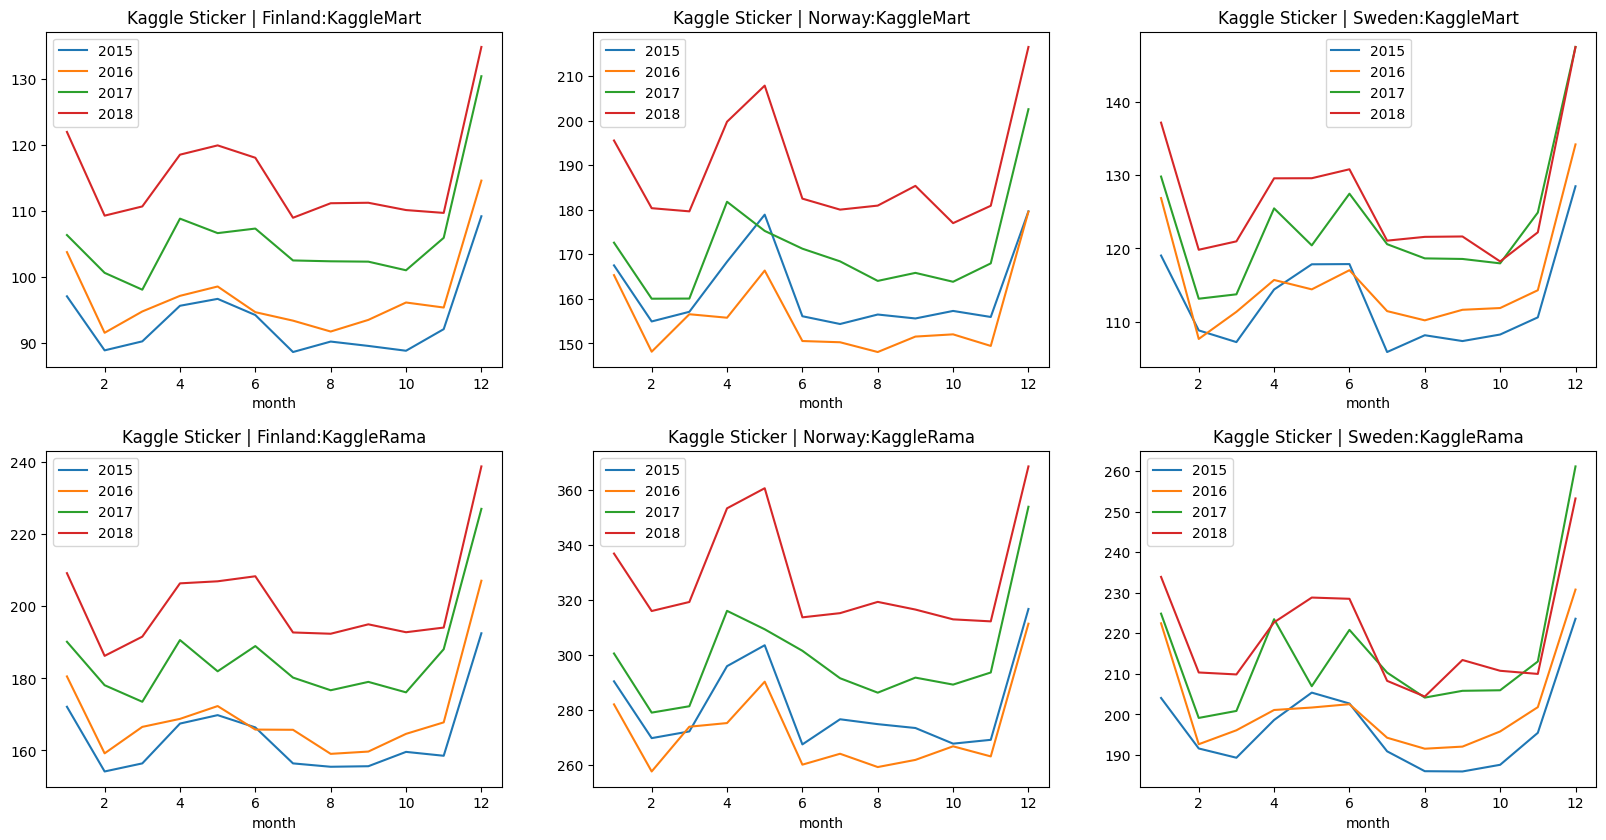

In [15]:
for product in ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']:
    fig = plt.figure(figsize=(20, 10), dpi=100)
    fig.subplots_adjust(hspace=0.25)
    for i, store in enumerate(['KaggleMart', 'KaggleRama']):
        for j, country in enumerate(['Finland', 'Norway', 'Sweden']):
            ax = fig.add_subplot(2, 3, (i*3+j+1))
            selection = (train['country']==country)&(train['store']==store)&(train['product']==product)
            selected = train[selection]
            for year in [2015, 2016, 2017, 2018]:
                selected[selected.year==year].set_index('date').groupby('month')['num_sold'].mean().plot(ax=ax, label=year)
            ax.set_title(f"{product} | {country}:{store}")
            ax.legend()
    plt.show()

##### Here we notice two important elements: seanality curves are different for each product and they also differ from year to year. Averaging the curves probably is safe bet for the future, as well as considering more relevant the recent years (thus weighting more the year 2018 for instance). For the sticker product, year 2017 seems particularly different from others.

##### We now proceed to examine seasonality even more in detail at a week level:


--- Kaggle Mug ---



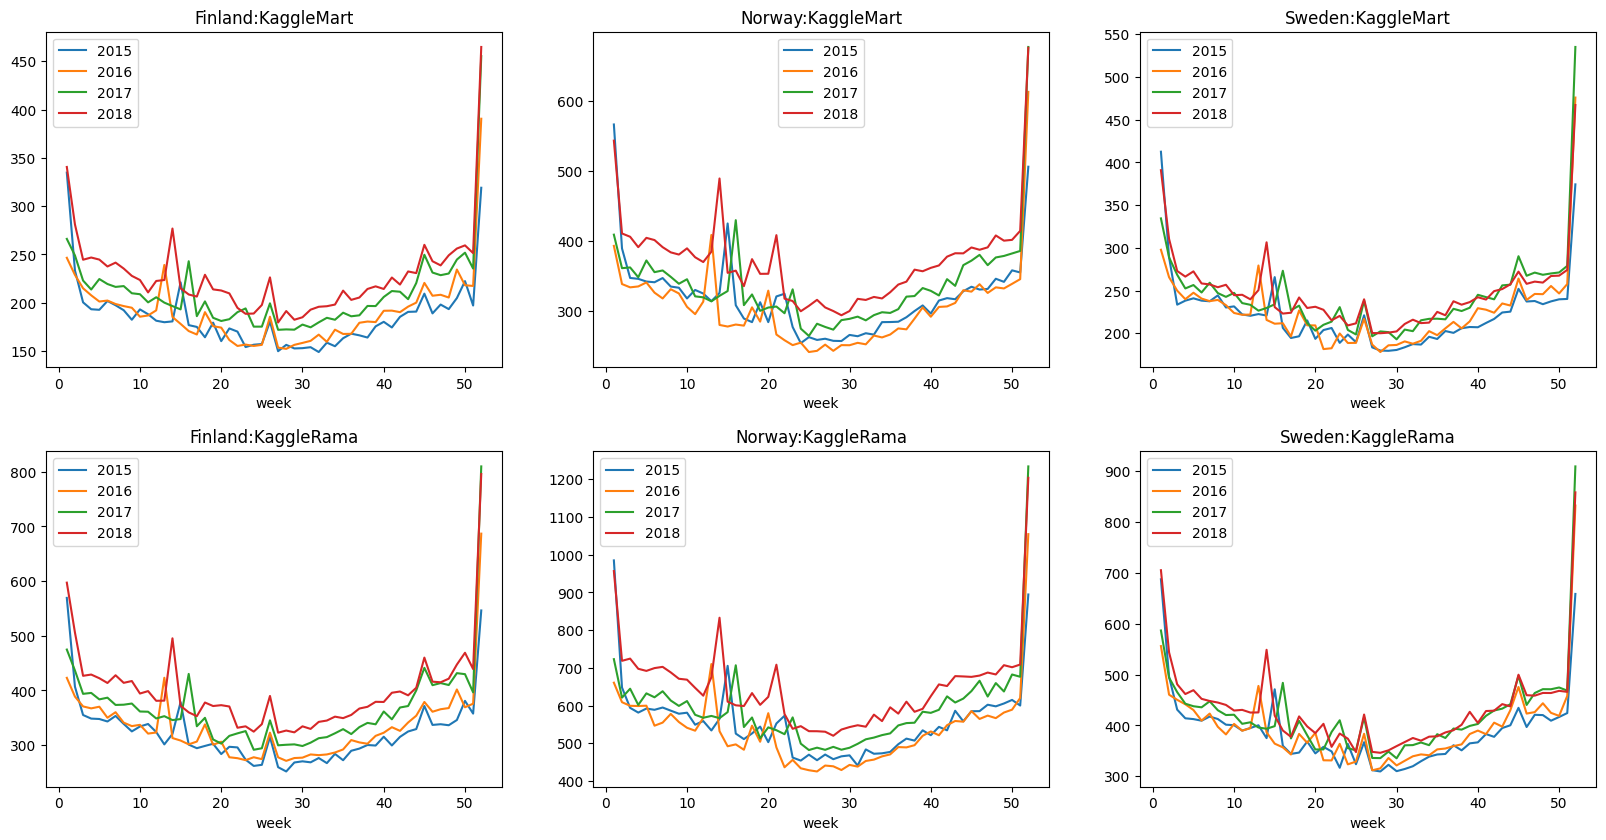


--- Kaggle Hat ---



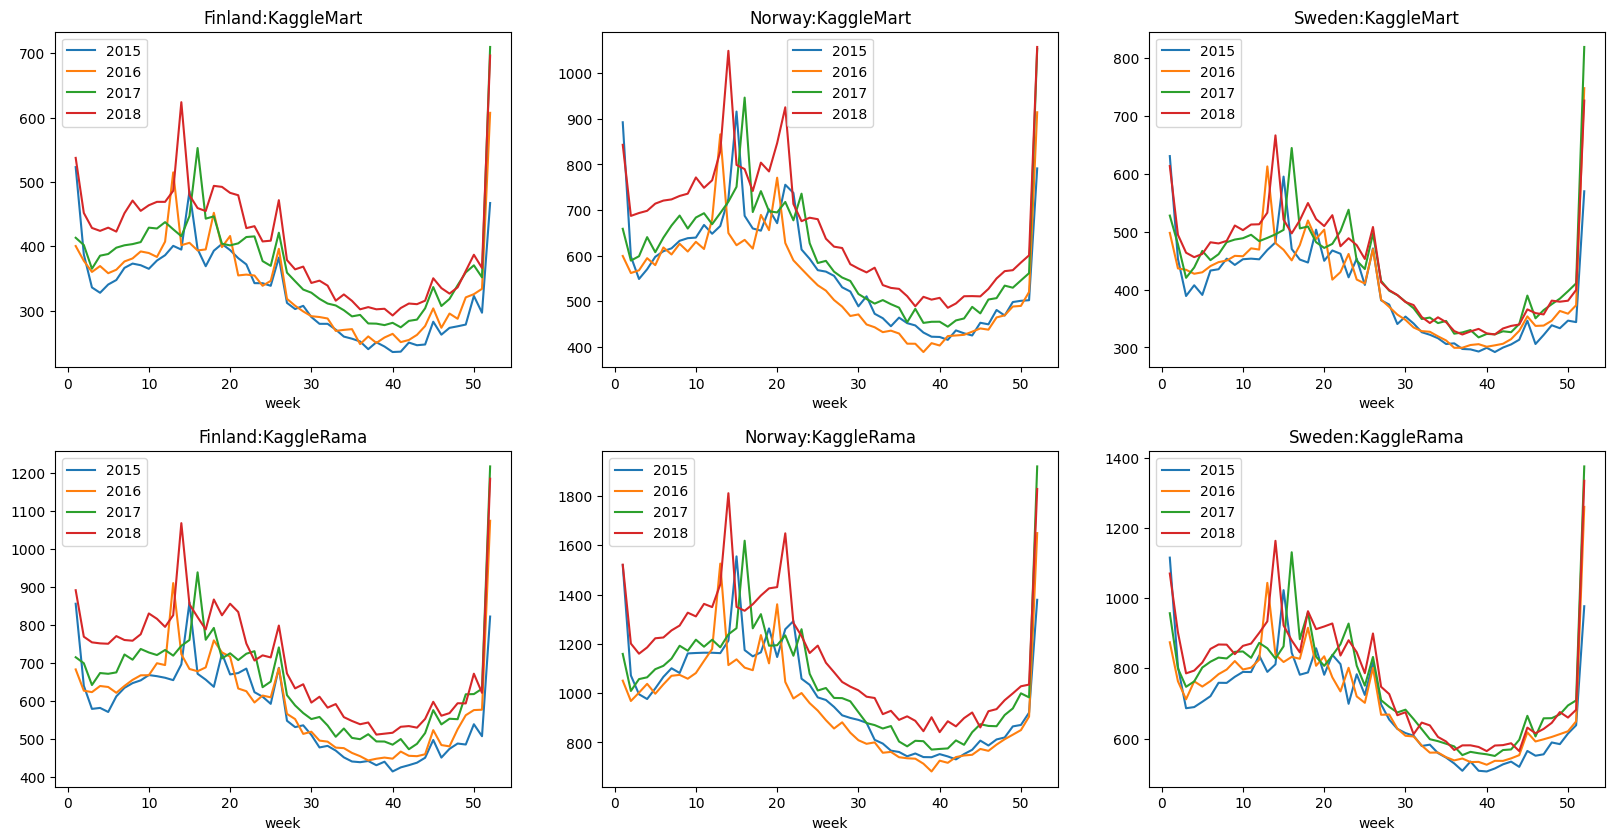


--- Kaggle Sticker ---



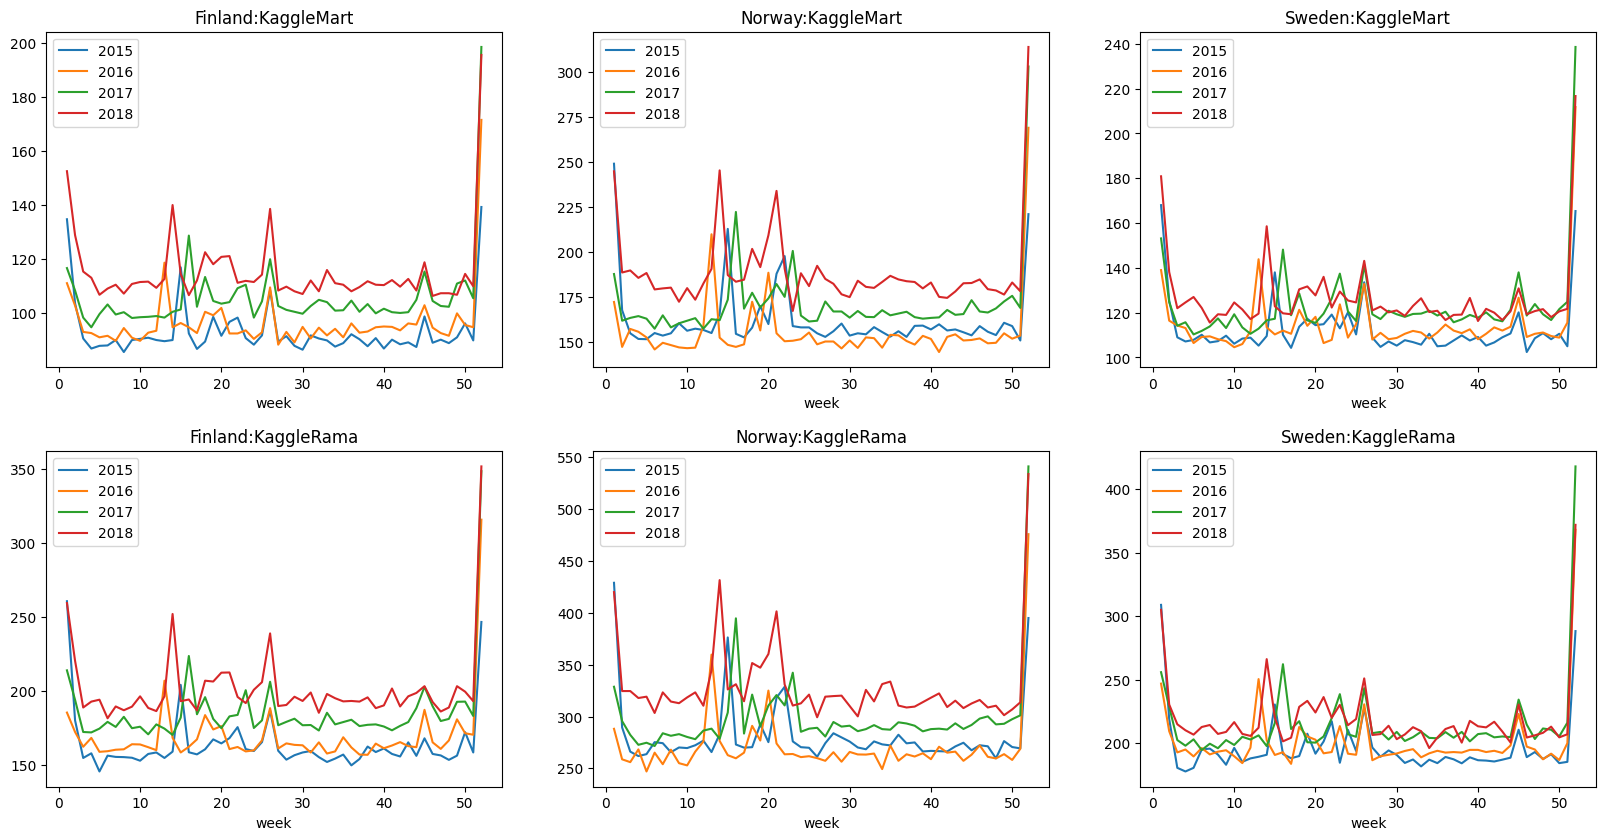

In [16]:
for product in ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']:
    print(f"\n--- {product} ---\n")
    fig = plt.figure(figsize=(20, 10), dpi=100)
    fig.subplots_adjust(hspace=0.25)
    for i, store in enumerate(['KaggleMart', 'KaggleRama']):
        for j, country in enumerate(['Finland', 'Norway', 'Sweden']):
            ax = fig.add_subplot(2, 3, (i*3+j+1))
            selection = (train['country']==country)&(train['store']==store)&(train['product']==product)
            selected = train[selection]
            for year in [2015, 2016, 2017, 2018]:
                selected[selected.year==year].set_index('date').groupby('week')['num_sold'].mean().plot(ax=ax, label=year)
            ax.set_title(f"{country}:{store}")
            ax.legend()
    plt.show()

##### At a week level we see that differences are due to peaks. Peaks seem different in Spring. Probably is is Easter effect.

##### We now start obeserving recurrences at a monthly level:


--- Kaggle Mug ---



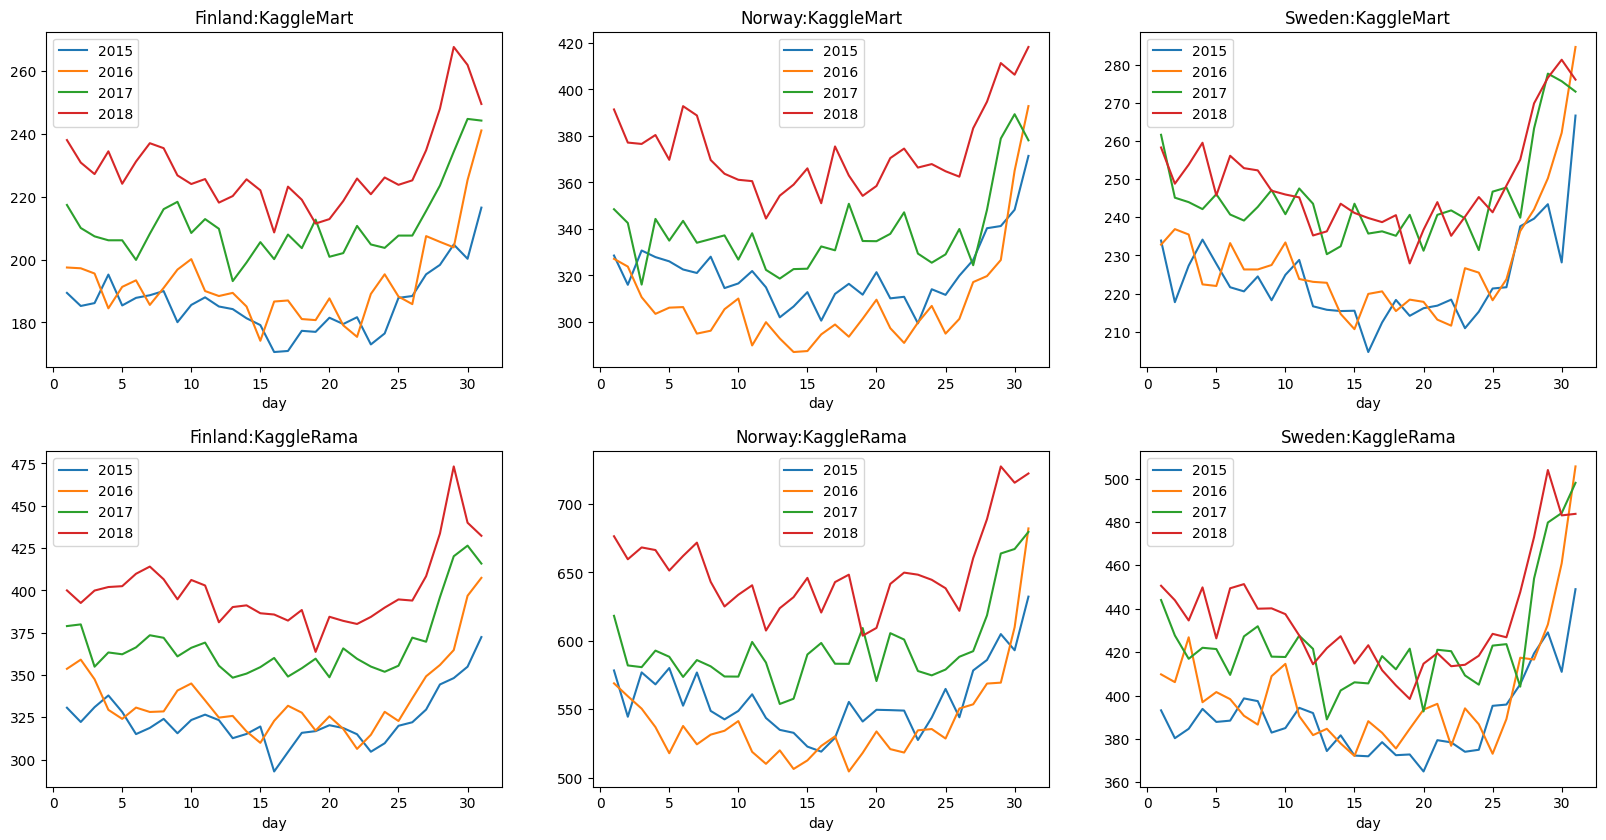


--- Kaggle Hat ---



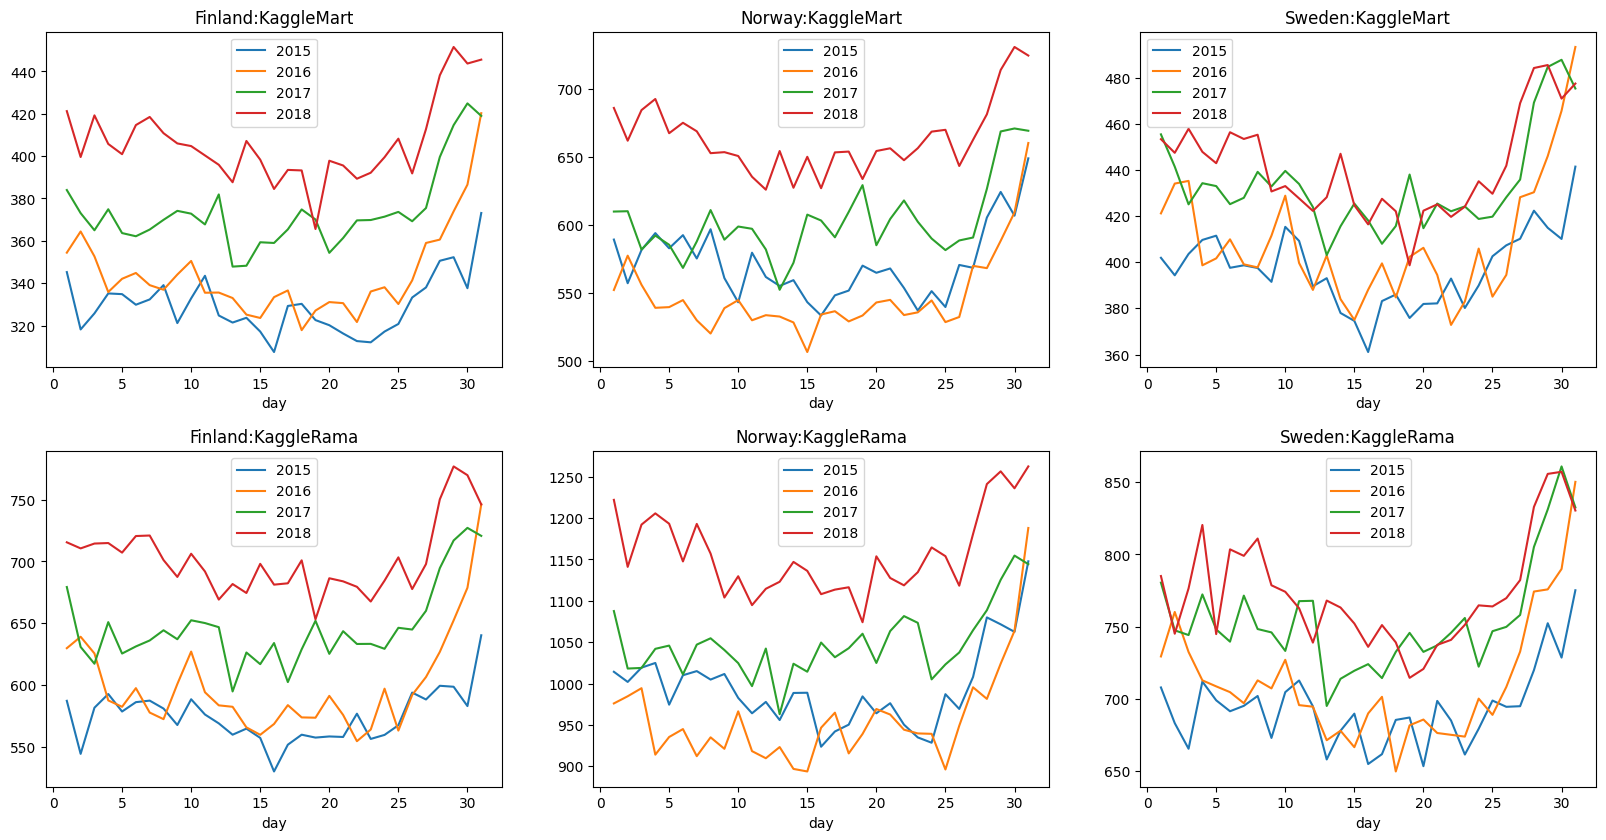


--- Kaggle Sticker ---



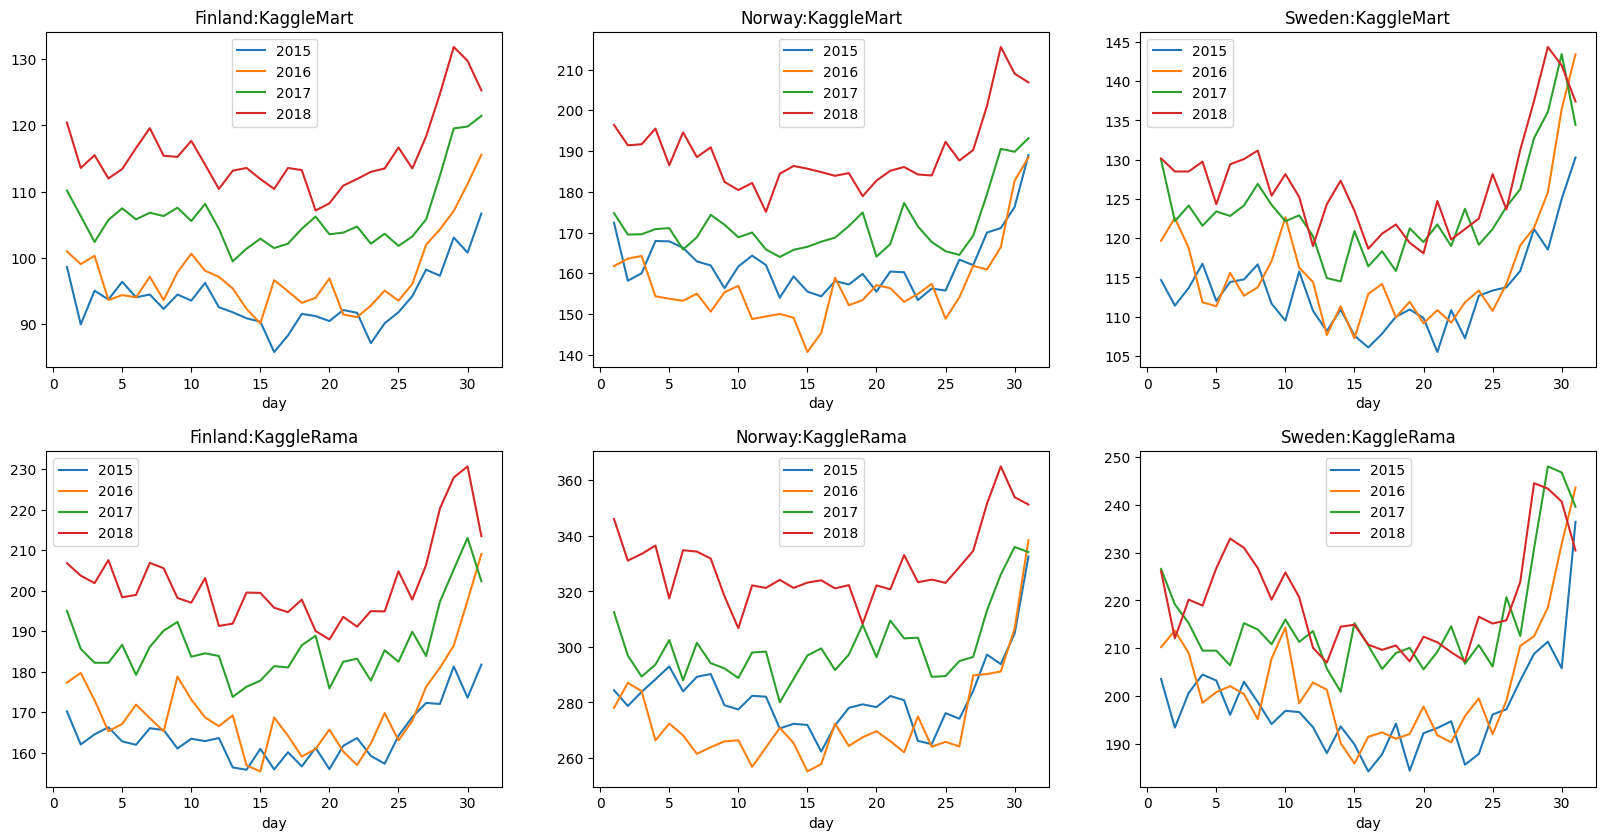

In [17]:
for product in ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']:
    print(f"\n--- {product} ---\n")
    fig = plt.figure(figsize=(20, 10), dpi=100)
    fig.subplots_adjust(hspace=0.25)
    for i, store in enumerate(['KaggleMart', 'KaggleRama']):
        for j, country in enumerate(['Finland', 'Norway', 'Sweden']):
            ax = fig.add_subplot(2, 3, (i*3+j+1))
            selection = (train['country']==country)&(train['store']==store)&(train['product']==product)
            selected = train[selection]
            for year in [2015, 2016, 2017, 2018]:
                selected[selected.year==year].set_index('date').groupby('day')['num_sold'].mean().plot(ax=ax, label=year)
            ax.set_title(f"{country}:{store}")
            ax.legend()
    plt.show()

##### The middle of the month usually presents less sales. The peak at the end may be influenced by seasonal peaks (end of year).

##### And we completed by inspecting at a day of the week level:


--- Kaggle Mug ---



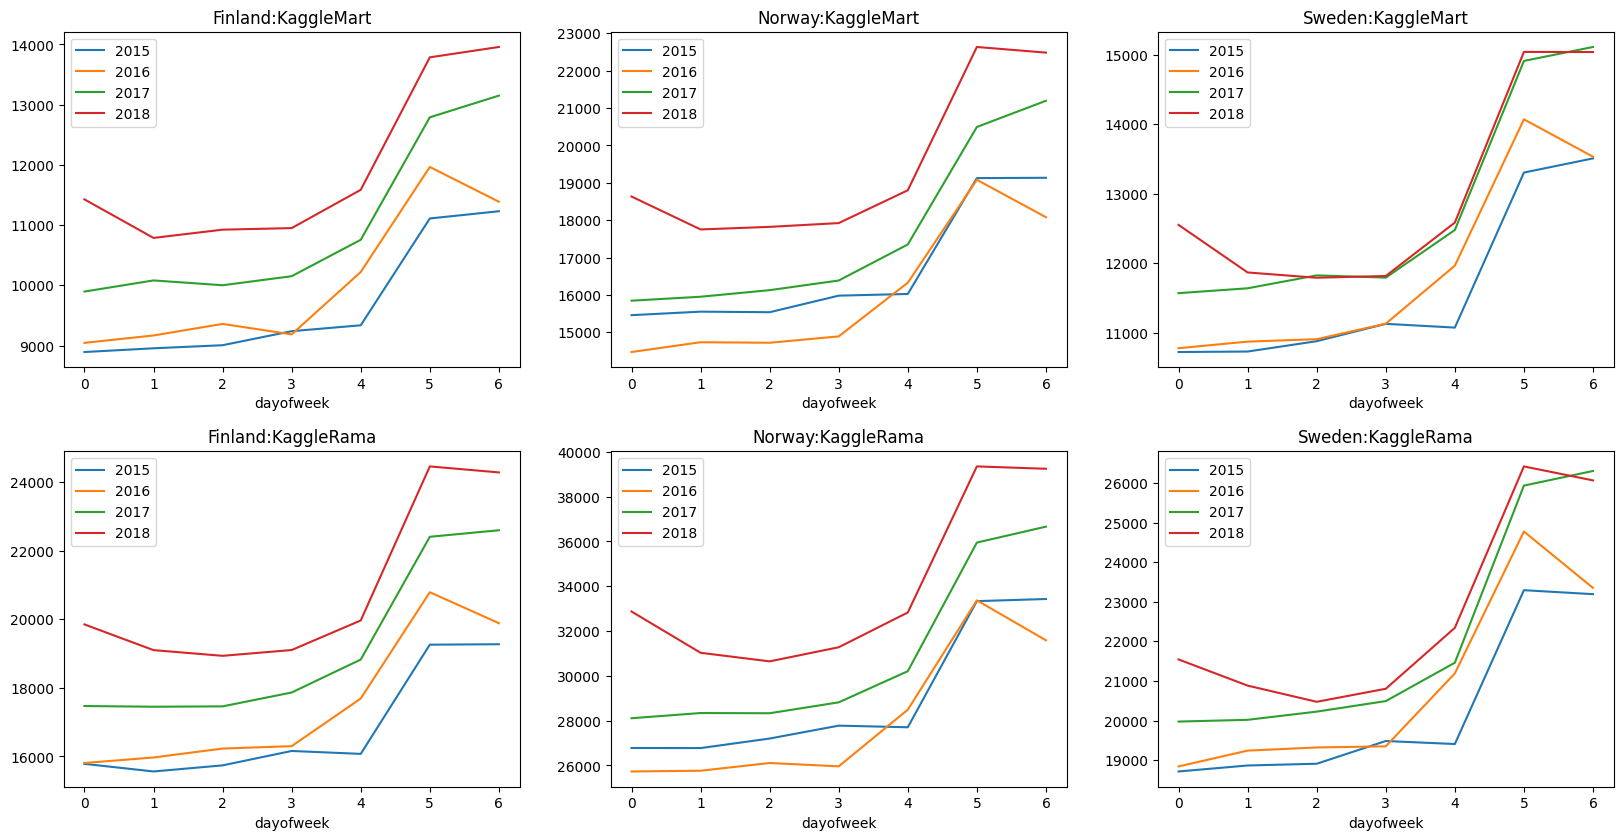


--- Kaggle Hat ---



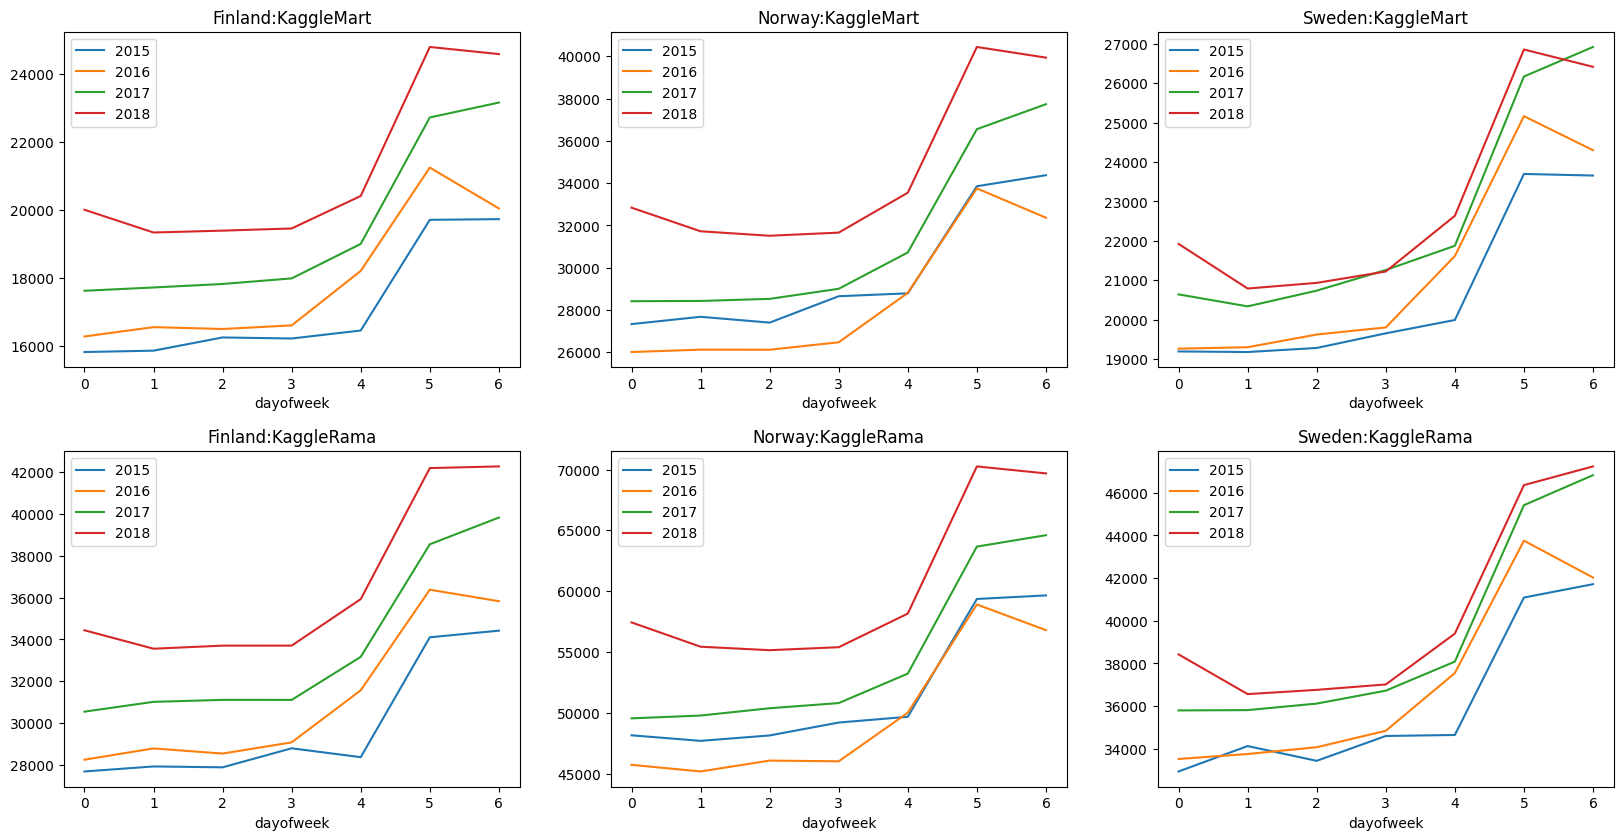


--- Kaggle Sticker ---



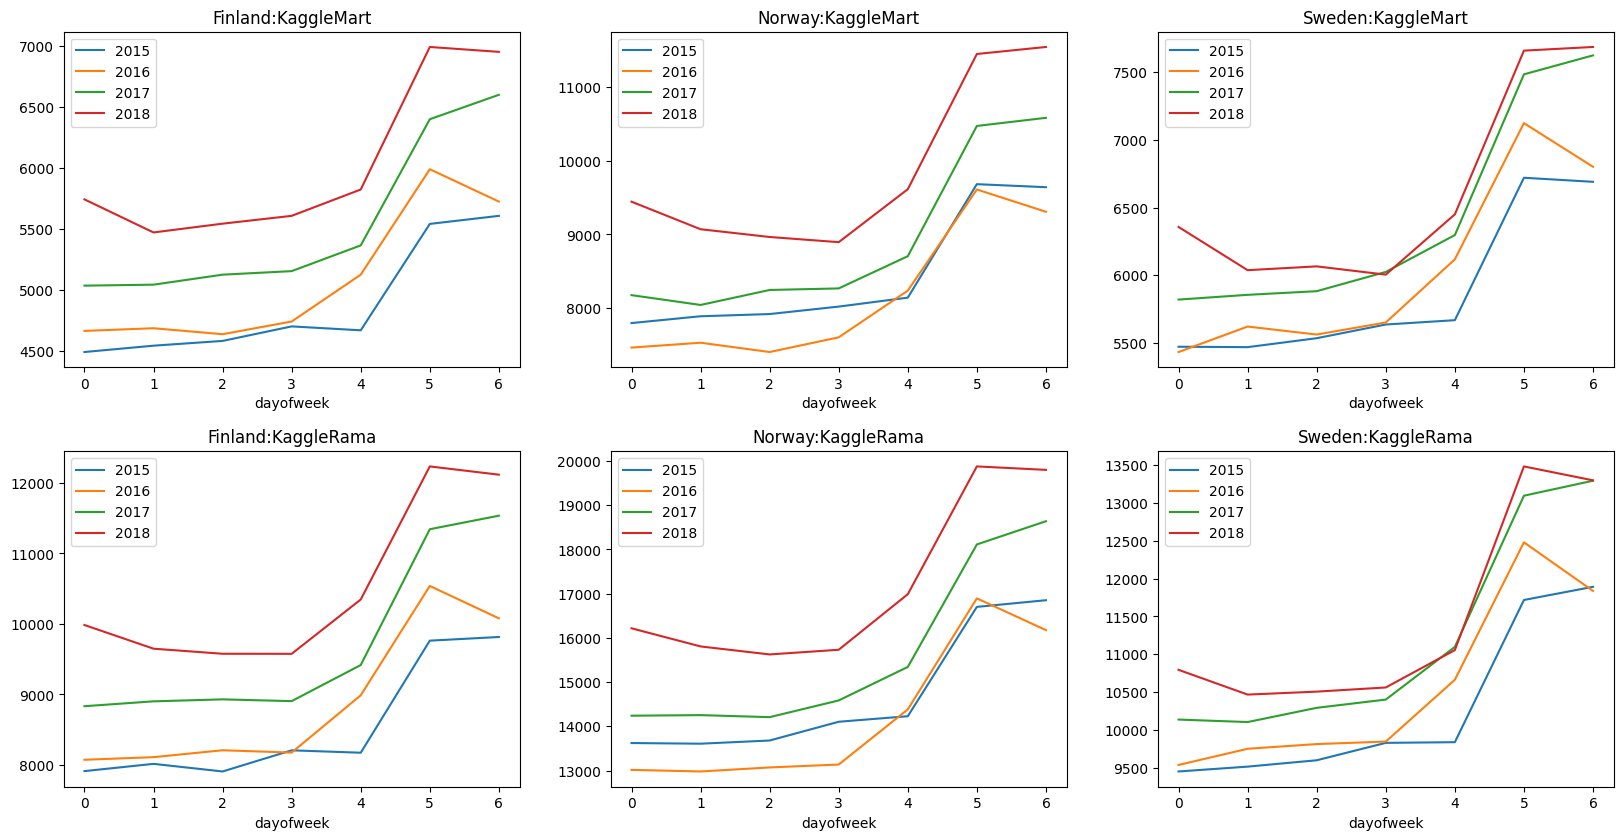

In [18]:
for product in ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']:
    print(f"\n--- {product} ---\n")
    fig = plt.figure(figsize=(20, 10), dpi=100)
    fig.subplots_adjust(hspace=0.25)
    for i, store in enumerate(['KaggleMart', 'KaggleRama']):
        for j, country in enumerate(['Finland', 'Norway', 'Sweden']):
            ax = fig.add_subplot(2, 3, (i*3+j+1))
            selection = (train['country']==country)&(train['store']==store)&(train['product']==product)
            selected = train[selection]
            for year in [2015, 2016, 2017, 2018]:
                selected[selected.year==year].set_index('date').groupby('dayofweek')['num_sold'].sum().plot(ax=ax, label=year)
            ax.set_title(f"{country}:{store}")
            ax.legend()
    plt.show()

##### Friday and the week-end are the best days, but Sundays are not always at the same level as Saturdays (it depends on the year - why?).

##### Based on the information we got we now proceed to feature engineering and to enrich the data (using festivities and GDP data).

In [19]:
festivities = pd.read_csv("./data/nordic_holidays.csv",
                          parse_dates=['date'],
                          usecols=['date', 'country', 'holiday'])

In [20]:
gdp = pd.read_csv("./data/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv")
gdp = np.concatenate([gdp[['year', 'GDP_Finland']].values, 
                      gdp[['year', 'GDP_Norway']].values, 
                      gdp[['year', 'GDP_Sweden']].values])
gdp = pd.DataFrame(gdp, columns=['year', 'gdp'])
gdp['country'] = ['Finland']*5 + ['Norway']*5 +['Sweden']*5

##### We now process the data and scale it. Since EDA revealed how the different characteristics of the series are mostly main effects (country and store), we focus on finding the way to model the interaction between products and time.

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def process_data(df):
    
    processed = dict()
    processed['row_id'] = df['row_id']
    
    print("creating dummies for main effects of time, country, store and product")
    to_dummies = ['country', 'store', 'product', 'month', 'week', 'day', 'dayofweek']
    for feat in to_dummies:
        tmp = pd.get_dummies(df[feat])
        for col in tmp.columns:
            processed[feat+'_'+str(col)] = tmp[col]
    
    print("creating dummies with 7 gg halo effect for Nordic holidays")
    tmp = pd.get_dummies(
        df.merge(festivities, on=['date', 'country'], how='left').sort_values('row_id')['holiday'])
    for col in tmp.columns:
            peak = tmp[col].values + tmp[col].rolling(7).mean().fillna(0).values
            processed['holiday_'+str(col)] =  peak
    
    print("creating interactions")
    high_lvl_interactions = [
        ['country', 'product', 'month'],
        ['country', 'product', 'week'],
        ['country', 'store', 'week'],
        ['country', 'product', 'month', 'day'],
        ['country', 'product', 'month', 'dayofweek'],
    ]
    for sel in high_lvl_interactions:
        tmp = pd.get_dummies(df[sel].apply(lambda row: '_'.join(row.values.astype(str)), axis=1))
        for col in tmp.columns:
            processed[col] = tmp[col]
            
    print("modelling time as continuous per each country")
    for country in ['Finland', 'Norway', 'Sweden']:
        processed[country + '_prog'] = ((df.row_id // 18) + 1) * (df['country']==country).astype(int)
        processed[country + '_prog^2'] = (processed[country + '_prog']**2)
        processed[country + '_prog^3'] = (processed[country + '_prog']**3)
    
    print("adding gdp")
    gdp_countries = df.merge(gdp, on=['country', 'year'], how='left')['gdp'].values
    for country in ['Finland', 'Norway', 'Sweden']:
        processed['gdp_'+ country] = gdp_countries * (df['country']==country).astype(int)
            
    print(f"completed processing {len(processed)-1} features")
    
    values = list()
    columns = list()
    for key, value in processed.items():
        values.append(np.array(value))
        columns.append(key)
        
    values = np.array(values).T        
    processed = pd.DataFrame(values, columns=columns)
    
    print("resorting row ids")
    processed = processed.sort_values('row_id').set_index('row_id')
    return processed

def process_target(df):
    target = pd.DataFrame({'row_id':df['row_id'], 'num_sold':df['num_sold']})
    target = target.sort_values('row_id').set_index('row_id')
    return target

train_test = process_data(train.append(test))

processed_train = train_test.iloc[:len(train)].copy()
processed_test = train_test.iloc[len(train):].copy()

target = np.ravel(process_target(train))

creating dummies for main effects of time, country, store and product
creating dummies with 7 gg halo effect for Nordic holidays
creating interactions
modelling time as continuous per each country
adding gdp
completed processing 4360 features
resorting row ids


##### Since EDA demonstrated that there is some kind of yearly change, we overweight more recent observations.

In [22]:
def weighting(df, weights):
    return df.year.replace(weights).values
    
weights = weighting(train, {2015:0.125, 2016:0.25, 2017:0.5, 2018:1})

In [23]:
processed_train.shape, train.shape, processed_test.shape, test.shape

((26298, 4360), (26298, 13), (6570, 4360), (6570, 12))

##### We prepare all the evaluation measures, both at an aggregate level, with exp transformation and at an individual cases level (for error analysis)

In [24]:
def SMAPE(y_true, y_pred):
    # From https://www.kaggle.com/cpmpml/smape-weirdness
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

def SMAPE_exp(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

def SMAPE_err(y_true, y_pred):
    # From https://www.kaggle.com/cpmpml/smape-weirdness
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return diff

##### We try modelling both an additive and a multiplicative predictor (for multiplicative you just need a log transoformation of the target because exponentiation of the sum of logs of the terms correspond to multiplications of the terms)

In [25]:
# due to float calculations the computation is approximated
a = 5
b = 7
print(a * b) # pure multiplicative
print(np.exp(np.log(a) + np.log(b))) # multiplicative made additive by log

35
34.99999999999999


In [26]:
from sklearn.linear_model import LinearRegression

addictive_model = LinearRegression().fit(processed_train, target, sample_weight=weights)
addictive_fit = addictive_model.predict(processed_train.values)
print(f"addictive fit: {SMAPE(y_true=target, y_pred=addictive_fit): 0.3f}")

addictive fit:  23.991


In [27]:
multiplicative_model = LinearRegression().fit(processed_train, np.log(target), sample_weight=weights)
multiplicative_fit = np.exp(multiplicative_model.predict(processed_train.values))
print(f"multiplicative fit: {SMAPE(y_true=target, y_pred=multiplicative_fit):0.3f}")

multiplicative fit: 4.638


##### It seems that the multiplicative model is better. We now use it to predict on the test set.

In [28]:
model = LinearRegression().fit(processed_train, np.log(target), sample_weight=weights)
#submission = pd.read_csv("../input/tabular-playground-series-jan-2022/sample_submission.csv")
submission = df_subm_example
preds = np.exp(model.predict(processed_test.values))

# selective rounding
dec = preds % 1
to_round = (dec<=0.3)|(dec>=0.7)
preds[to_round] = np.round(preds[to_round])

submission.num_sold = preds
submission.to_csv("submission.csv", index=False)

##### For testing purposes we refit the model only on years 2015-2017 using 2018 as an hold-out test.

In [29]:
log_target = np.log(target)
train_set = list(train.index[train.date<'2018-01-01'])
val_set = list(train.index[train.date>='2018-01-01'])
model = LinearRegression()

model.fit(processed_train.iloc[train_set], log_target[train_set], sample_weight=weights[train_set])
preds = np.exp(model.predict(processed_train.iloc[val_set].values))

# selective rounding
dec = preds % 1
to_round = (dec<=0.3)|(dec>=0.7)
preds[to_round] = np.round(preds[to_round])

smape = SMAPE(y_true=target[val_set], y_pred=preds)
print(f"hold-out smape: {smape}")

hold-out smape: 6.579052053994989


### If you liked the notebook, consider to upvote, thank you and happy Kaggling!

In [153]:
import xgboost as xgb

In [154]:
data_dmatrix = xgb.DMatrix(data=processed_train,label=log_target)

In [155]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_train, log_target, test_size=0.2, random_state=123)

In [187]:
xg_reg = xgb.XGBRegressor(objective ='survival:cox', colsample_bytree = 0.1, learning_rate = 0.1,
                max_depth = 15, alpha = 10, n_estimators = 10)

In [188]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=12,
             num_parallel_tree=1, objective='survival:cox', predictor='auto',
             random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=None,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [190]:
preds = np.exp(xg_reg.predict(X_test))
# selective rounding
dec = preds % 1
to_round = (dec<=0.3)|(dec>=0.7)
preds[to_round] = np.round(preds[to_round])
smape = SMAPE(y_true=y_test, y_pred=preds)
print(f"hold-out smape: {smape}")

hold-out smape: 95.20445688872626


In [120]:
from catboost import CatBoostRegressor
import catboost as cb

In [31]:
categorical_features_indices = np.where(processed_train.dtypes != float)[0]

In [121]:
train_dataset = cb.Pool(processed_train.iloc[train_set], log_target[train_set]) 
test_dataset = cb.Pool(processed_train.iloc[val_set], log_target[val_set])

In [122]:
model = CatBoostRegressor(loss_function='RMSE', depth=2, learning_rate=0.3, iterations=3000, 
    random_seed=18, 
    od_type='IncToDec',
    od_wait=20, task_type='CPU'
)
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 5.5863365	test: 5.5824689	best: 5.5824689 (0)	total: 27.7ms	remaining: 2.74s
1:	learn: 5.4210214	test: 5.4171795	best: 5.4171795 (1)	total: 33ms	remaining: 1.61s
2:	learn: 5.2607326	test: 5.2569053	best: 5.2569053 (2)	total: 37.1ms	remaining: 1.2s
3:	learn: 5.1053231	test: 5.1015098	best: 5.1015098 (3)	total: 42.8ms	remaining: 1.03s
4:	learn: 4.9546487	test: 4.9508547	best: 4.9508547 (4)	total: 48.3ms	remaining: 918ms
5:	learn: 4.8085736	test: 4.8048155	best: 4.8048155 (5)	total: 52.6ms	remaining: 824ms
6:	learn: 4.6668622	test: 4.6631683	best: 4.6631683 (6)	total: 58ms	remaining: 771ms
7:	learn: 4.5295518	test: 4.5259143	best: 4.5259143 (7)	total: 63.6ms	remaining: 731ms
8:	learn: 4.3963664	test: 4.3927972	best: 4.3927972 (8)	total: 68.1ms	remaining: 689ms
9:	learn: 4.2673469	test: 4.2638193	best: 4.2638193 (9)	total: 72.1ms	remaining: 649ms
10:	learn: 4.1422874	test: 4.1388083	best: 4.1388083 (10)	total: 77.4ms	remaining: 626ms
11:	learn: 4.0208969	test: 4.0174653	best: 4.0

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [136]:
model = CatBoostRegressor(loss_function='RMSE', depth=8, learning_rate=0.25, iterations=200, 
    l2_leaf_reg = 0.5,
    random_seed=18, 
    od_type='IncToDec',
    od_wait=20, task_type='CPU'
)

model.fit(
    processed_train.iloc[train_set], log_target[train_set], use_best_model=True,
    cat_features=categorical_features_indices,
    eval_set=(processed_train.iloc[val_set], log_target[val_set]),
    verbose=False,  
    plot=True, 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [137]:
preds = np.exp(model.predict(processed_train.iloc[val_set].values))

In [138]:
# selective rounding
dec = preds % 1
to_round = (dec<=0.3)|(dec>=0.7)
preds[to_round] = np.round(preds[to_round])

smape = SMAPE(y_true=target[val_set], y_pred=preds)
print(f"hold-out smape: {smape}")

hold-out smape: 6.9515880092081135


In [104]:
model.fit(
    processed_train, log_target, use_best_model=True,
    cat_features=categorical_features_indices,
    verbose=False,  
    plot=True,
)
preds = np.exp(model.predict(processed_test.values))

# selective rounding
dec = preds % 1
to_round = (dec<=0.3)|(dec>=0.7)
preds[to_round] = np.round(preds[to_round])

submission.num_sold = preds
submission.to_csv("submission.csv", index=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from tensorflow import keras

In [31]:
# # LSTM

#  # define the Autoencoder model
# #processed_train.iloc[train_set], log_target[train_set]
# model = Sequential()
# #model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# #model.add(LSTM(64, activation='relu', return_sequences=True))
# #model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(LSTM(64, input_shape=(processed_train.shape[1], ), return_sequences=True))
# #model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(32, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

In [43]:
model = Sequential()
model.add(Dense(units = 16, activation = 'relu', input_shape = ((processed_train.shape[1], ))))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                69776     
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 70,353
Trainable params: 70,353
Non-trainable params: 0
_________________________________________________________________


In [46]:
processed_train.shape[0],

(26298,)

In [60]:
type(log_target)

numpy.ndarray

In [61]:
log_target = np.append(log_target, log_target[len(log_target) -1])


In [62]:
log_target

array([5.79605775, 6.25382881, 4.98360662, ..., 7.2730926 , 5.96100534,
       5.96100534])

In [47]:
processed_train

country_Finland  country_Norway  country_Sweden  store_KaggleMart  \
row_id                                                                       
0.0                  1.0             0.0             0.0               1.0   
1.0                  1.0             0.0             0.0               1.0   
2.0                  1.0             0.0             0.0               1.0   
3.0                  1.0             0.0             0.0               0.0   
4.0                  1.0             0.0             0.0               0.0   
...                  ...             ...             ...               ...   
26293.0              0.0             0.0             1.0               1.0   
26294.0              0.0             0.0             1.0               1.0   
26295.0              0.0             0.0             1.0               0.0   
26296.0              0.0             0.0             1.0               0.0   
26297.0              0.0             0.0             1.0               0.0   

         store_KaggleRama  product_Kaggle Hat  product_Kaggle Mug  \
row_id                                                              
0.0                   0.0                 0.0                 1.0   
1.0                   0.0                 1.0                 0.0   
2.0                   0.0                 0.0                 0.0   
3.0                   1.0                 0.0                 1.0   
4.0                   1.0                 1.0                 0.0   
...                   ...                 ...                 ...   
26293.0               0.0                 1.0                 0.0   
26294.0               0.0                 0.0                 0.0   
26295.0               1.0                 0.0                 1.0   
26296.0               1.0                 1.0                 0.0   
26297.0               1.0                 0.0                 0.0   

         product_Kaggle Sticker  month_1  month_2  ...  Finland_prog^3  \
row_id                                             ...                   
0.0                         0.0      1.0      0.0  ...             1.0   
1.0                         0.0      1.0      0.0  ...             1.0   
2.0                         1.0      1.0      0.0  ...             1.0   
3.0                         0.0      1.0      0.0  ...             1.0   
4.0                         0.0      1.0      0.0  ...             1.0   
...                         ...      ...      ...  ...             ...   
26293.0                     0.0      0.0      0.0  ...             0.0   
26294.0                     1.0      0.0      0.0  ...             0.0   
26295.0                     0.0      0.0      0.0  ...             0.0   
26296.0                     0.0      0.0      0.0  ...             0.0   
26297.0                     1.0      0.0      0.0  ...             0.0   

         Norway_prog  Norway_prog^2  Norway_prog^3  Sweden_prog  \
row_id                                                            
0.0              0.0            0.0            0.0          0.0   
1.0              0.0            0.0            0.0          0.0   
2.0              0.0            0.0            0.0          0.0   
3.0              0.0            0.0            0.0          0.0   
4.0              0.0            0.0            0.0          0.0   
...              ...            ...            ...          ...   
26293.0          0.0            0.0            0.0       1461.0   
26294.0          0.0            0.0            0.0       1461.0   
26295.0          0.0            0.0            0.0       1461.0   
26296.0          0.0            0.0            0.0       1461.0   
26297.0          0.0            0.0            0.0       1461.0   

         Sweden_prog^2  Sweden_prog^3  gdp_Finland  gdp_Norway  gdp_Sweden  
row_id                                                                      
0.0                0.0   0.000000e+00       234.44         0.0       0.000  
1.0                0.0   0.000

In [63]:
log_target.shape

(26299,)

In [66]:
history = model.fit(processed_train, log_target.transpose(), epochs=50, batch_size=64, validation_split=0.5, verbose=1)

ValueError: Data cardinality is ambiguous:
  x sizes: 13150
  y sizes: 13149
Make sure all arrays contain the same number of samples.

In [151]:
preds = np.exp(model.predict(processed_train.iloc[val_set].values))
# selective rounding
dec = preds % 1
to_round = (dec<=0.3)|(dec>=0.7)
preds[to_round] = np.round(preds[to_round])
smape = SMAPE(y_true=target[val_set], y_pred=preds)
print(f"hold-out smape: {smape}")


hold-out smape: 195.80745676688477


In [ ]:


model.fit(
    processed_train, log_target, use_best_model=True,
    cat_features=categorical_features_indices,
    verbose=False,  
    plot=True,
)
preds = np.exp(model.predict(processed_test.values))

# selective rounding
dec = preds % 1
to_round = (dec<=0.3)|(dec>=0.7)
preds[to_round] = np.round(preds[to_round])

submission.num_sold = preds
submission.to_csv("submission.csv", index=False)

In [140]:
print(log_target.shape)
print(processed_train.shape)


(26298,)
(26298, 4360)


In [62]:
myList = list(range(1,5))
myList[:-1]

[1, 2, 3]